In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, Image, Markdown
from pathlib import Path
import sys
from scipy.stats import poisson as sp_poisson, nbinom as sp_nbinom

In [2]:
TAXI_PATHS = [
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-01.parquet'),
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-02.parquet'),
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-03.parquet'),
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-04.parquet'),
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-05.parquet'),
    Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/yellow_tripdata_2024-06.parquet'),
]
LOOKUP_CSV = Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/taxi_zone_lookup.csv')
TAXI_MAX_ROWS = 4_0000_000

# Bike configuration
BIKE_DATA_ROOT = Path('/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/data/raw/citibike')
BIKE_GLOB = '2024*-citibike-tripdata_*.csv'
BIKE_MAX_ROWS = 5_0000_000

# Shared configuration
BUCKET_BASE = '15min'
TAXI_MIN_MEAN = 1.0
TAXI_MIN_NONZERO = 0.3
BIKE_MIN_MEAN = 0.5
BIKE_MIN_NONZERO = 0.2

In [3]:
# Add src/ to path for project helpers
root = Path.cwd().resolve()
for candidate in [root, *root.parents]:
    if (candidate / 'src').exists():
        sys.path.append(str(candidate / 'src'))
        break
from modeling.poisson_zone import load_taxi_pickups, attach_zone_metadata, bucket_counts_by_group


In [4]:
def fit_nb(series: pd.Series):
    """Method-of-moments NB fit returning (r, p)."""
    mean = series.mean()
    var = series.var(ddof=0)
    if var <= mean or mean <= 0:
        return np.nan, np.nan
    r = mean ** 2 / (var - mean)
    p = r / (r + mean)
    return r, p

def is_rush(hour, ranges=[(7, 10), (16, 19)]):
    return any(lo <= hour < hi for lo, hi in ranges)

def cohort_label(is_weekend: pd.Series, is_rush: pd.Series) -> pd.Series:
    weekend = np.where(is_weekend, 'weekend', 'weekday')
    rush = np.where(is_rush, 'rush', 'offpeak')
    return pd.Series(weekend + '_' + rush, index=is_weekend.index)


In [5]:

def load_taxi_data():
    """Load and prepare taxi data from multiple months."""
    
    print(f"Loading {len(TAXI_PATHS)} taxi files...")
    frames = []
    
    for path in TAXI_PATHS:
        if not path.exists():
            print(f"  Warning: {path.name} not found, skipping...")
            continue
            
        print(f"  Reading {path.name}...")
        trips = load_taxi_pickups(path, max_rows=TAXI_MAX_ROWS)
        frames.append(trips)
    
    if not frames:
        raise FileNotFoundError("No taxi data files were successfully loaded")
    
    # Combine all months
    print("  Concatenating data...")
    trips = pd.concat(frames, ignore_index=True)
    
    # Process combined data
    trips = attach_zone_metadata(trips, LOOKUP_CSV).dropna(subset=['Zone'])
    trips['event_time'] = trips['event_time'].dt.tz_convert(None)
    trips['month'] = trips['event_time'].dt.month  # Track which month
    trips['hour'] = trips['event_time'].dt.hour
    trips['is_weekend'] = trips['event_time'].dt.dayofweek >= 5
    trips['is_rush'] = trips['hour'].apply(is_rush)
    trips['cohort'] = cohort_label(trips['is_weekend'], trips['is_rush'])
    trips['bucket_start'] = trips['event_time'].dt.floor(BUCKET_BASE)
    
    # Screen for active zones
    base_counts = bucket_counts_by_group(trips, freq=BUCKET_BASE, group_cols='Zone')
    means = base_counts.mean()
    nonzero = (base_counts > 0).mean()
    active_zones = [z for z in base_counts.columns 
                    if means[z] >= TAXI_MIN_MEAN and nonzero[z] >= TAXI_MIN_NONZERO]
    active_zones = sorted(active_zones) or sorted(trips['Zone'].unique())
    
    print(f"Loaded {len(trips):,} taxi trips across {len(active_zones)} active zones (Jan-Jun 2024)")
    return trips, active_zones, 'Zone'

def load_bike_data():
    """Load and prepare Citi Bike data."""
    files = sorted(BIKE_DATA_ROOT.glob(BIKE_GLOB))
    if not files:
        raise FileNotFoundError(f'No Citi Bike CSVs matching {BIKE_GLOB}')
    
    frames = []
    for i, f in enumerate(files):
        frames.append(pd.read_csv(
            f,
            nrows=BIKE_MAX_ROWS if (BIKE_MAX_ROWS and i == 0) else None,
            dtype={'start_station_id': str, 'end_station_id': str},
            low_memory=False,
        ))
    bike = pd.concat(frames, ignore_index=True)
    bike['event_time'] = pd.to_datetime(bike['started_at'])
    bike = bike.dropna(subset=['start_station_id', 'start_lat', 'start_lng'])
    bike['start_station_id'] = bike['start_station_id'].astype(str)
    bike['hour'] = bike['event_time'].dt.hour
    bike['is_weekend'] = bike['event_time'].dt.dayofweek >= 5
    bike['bucket_start'] = bike['event_time'].dt.floor(BUCKET_BASE)
    
    def label(row):
        weekend = 'weekend' if row['is_weekend'] else 'weekday'
        rush = 'rush' if (7 <= row['hour'] < 10) or (16 <= row['hour'] < 19) else 'offpeak'
        return f"{weekend}_{rush}"
    
    bike['cohort'] = bike.apply(label, axis=1)
    bike = bike.rename(columns={'start_station_id': 'StationID'})
    
    # Screen for active stations
    base_counts = bucket_counts_by_group(bike, freq=BUCKET_BASE, group_cols='StationID')
    means = base_counts.mean()
    nonzero = (base_counts > 0).mean()
    active_stations = [sid for sid in base_counts.columns 
                       if means[sid] >= BIKE_MIN_MEAN and nonzero[sid] >= BIKE_MIN_NONZERO]
    active_stations = sorted(active_stations)
    
    print(f"Loaded {len(bike):,} bike trips across {len(active_stations)} active stations")
    return bike, active_stations, 'StationID'

# Load data
taxi_trips, taxi_zones, taxi_group_col = load_taxi_data()
bike_trips, bike_stations, bike_group_col = load_bike_data()


Loading 6 taxi files...
  Reading yellow_tripdata_2024-01.parquet...
  Reading yellow_tripdata_2024-02.parquet...
  Reading yellow_tripdata_2024-03.parquet...
  Reading yellow_tripdata_2024-04.parquet...
  Reading yellow_tripdata_2024-05.parquet...
  Reading yellow_tripdata_2024-06.parquet...
  Concatenating data...
Loaded 20,266,415 taxi trips across 61 active zones (Jan-Jun 2024)
Loaded 18,795,711 bike trips across 704 active stations


In [6]:
# ============================================================================
# Dashboard Creation
# ============================================================================

def create_combined_figure(series, mean, var, nb_r, nb_p, diffs, wait_mean, title_prefix):
    """Create a 2-subplot figure with arrivals and wait times."""
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Arrivals per Bucket', 'Wait Time Distribution'),
        horizontal_spacing=0.15
    )
    
    # Left plot: Arrival counts
    grid = np.arange(0, max(series.max(), int(series.quantile(0.99)) + 5) + 1)
    obs = series.value_counts().reindex(grid, fill_value=0).values
    
    fig.add_trace(go.Bar(x=grid, y=obs, name='Observed', 
                         marker=dict(color='#4B6BFB'), opacity=0.75), row=1, col=1)
    
    pois_exp = sp_poisson.pmf(grid, mean) * len(series)
    fig.add_trace(go.Scatter(x=grid, y=pois_exp, mode='lines', name='Poisson',
                            line=dict(color='#FFA500', width=2)), row=1, col=1)
    
    if np.isfinite(nb_r) and np.isfinite(nb_p) and nb_r > 0 and 0 < nb_p < 1:
        nb_exp = sp_nbinom.pmf(grid, nb_r, nb_p) * len(series)
        fig.add_trace(go.Scatter(x=grid, y=nb_exp, mode='lines', name='Neg-Bin',
                                line=dict(color='#D62728', width=3)), row=1, col=1)
    
    # Right plot: Wait times
    if not diffs.empty and wait_mean > 0:
        fig.add_trace(go.Histogram(x=diffs, nbinsx=100, name='Empirical Wait',
                                   marker=dict(color='#4B6BFB'), opacity=0.75,
                                   histnorm='probability density'), row=1, col=2)
        
        lam = 1 / wait_mean
        x = np.linspace(0, diffs.max(), 200)
        pdf = lam * np.exp(-lam * x)
        fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name='Exponential',
                                line=dict(color="#99FF00", width=2)), row=1, col=2)
    
    fig.update_xaxes(title_text='Arrivals', row=1, col=1)
    fig.update_yaxes(title_text='Frequency', row=1, col=1)
    fig.update_xaxes(title_text='Minutes', row=1, col=2)
    fig.update_yaxes(title_text='Density', row=1, col=2)
    
    fig.update_layout(
        height=450, 
        showlegend=True, 
        template='plotly_white',
        title_text=title_prefix,
        title_x=0.5,
        title_xanchor='center'
    )
    return fig

def build_dashboard(trips_data, locations, group_col, min_mean, min_nonzero, title):
    """Build a dashboard for either taxi or bike data."""
    location_dd = widgets.Dropdown(options=locations, description='Location')
    cohort_opts = ['All trips'] + sorted(trips_data['cohort'].unique())
    cohort_dd = widgets.Dropdown(options=cohort_opts, description='Cohort')
    freq_dd = widgets.Dropdown(options=['5min','15min','30min','1H'], value='15min', description='Bucket')
    out = widgets.Output()

    def refresh():
        out.clear_output(wait=True)
        with out:
            cohort = cohort_dd.value
            subset = trips_data if cohort == 'All trips' else trips_data[trips_data['cohort'] == cohort]
            
            if subset.empty:
                print('No trips for this cohort selection.')
                return
            
            counts = bucket_counts_by_group(subset, freq=freq_dd.value, group_cols=group_col)
            
            if location_dd.value not in counts.columns:
                print('Location missing for this selection.')
                return
            
            series = counts[location_dd.value]
            nonzero_frac = (series > 0).mean()
            mean = series.mean()
            
            if mean < min_mean or nonzero_frac < min_nonzero:
                print(f'Selection too sparse (mean={mean:.2f}, nonzero={nonzero_frac:.2f}).')
                return
            
            var = series.var(ddof=0)
            disp = var / mean if mean > 0 else np.nan
            nb_r, nb_p = fit_nb(series)
            
            # Calculate wait times
            location_subset = subset[subset[group_col] == location_dd.value].sort_values('event_time')
            diffs = location_subset['event_time'].diff().dropna().dt.total_seconds() / 60
            diffs = diffs[(diffs > 0) & (diffs < 180)]
            wait_mean = diffs.mean() if not diffs.empty else 0
            
            # Create combined figure
            fig = create_combined_figure(series, mean, var, nb_r, nb_p, diffs, wait_mean,
                                        f"{location_dd.value} ({cohort}, {freq_dd.value})")
            display(fig)
            
            # Summary statistics
            summary = pd.DataFrame([{
                'location': location_dd.value,
                'cohort': cohort,
                'freq': freq_dd.value,
                'mean_arrivals': mean,
                'variance': var,
                'dispersion': disp,
                'nb_r': nb_r,
                'nb_p': nb_p,
                'mean_wait_min': wait_mean if not diffs.empty else np.nan
            }])
            display(summary)

    location_dd.observe(lambda _: refresh(), names='value')
    cohort_dd.observe(lambda _: refresh(), names='value')
    freq_dd.observe(lambda _: refresh(), names='value')
    
    refresh()
    return widgets.VBox([
        widgets.HTML(f"<h3>{title}</h3>"),
        widgets.HBox([location_dd, cohort_dd]),
        freq_dd,
        out
    ])

In [7]:
# ============================================================================
# Main Dashboard with Tabs
# ============================================================================

taxi_dashboard = build_dashboard(taxi_trips, taxi_zones, taxi_group_col, 
                                 TAXI_MIN_MEAN, TAXI_MIN_NONZERO, "🚕 Taxi Dashboard")
bike_dashboard = build_dashboard(bike_trips, bike_stations, bike_group_col,
                                 BIKE_MIN_MEAN, BIKE_MIN_NONZERO, "🚲 Bike Dashboard")

tabs = widgets.Tab(children=[taxi_dashboard, bike_dashboard])
tabs.set_title(0, 'Taxi')
tabs.set_title(1, 'Citi Bike')

display(tabs)


### Static wait-time snapshot

Rendered inline so reviewers can see representative arrival + exponential overlays without running the ipywidgets.

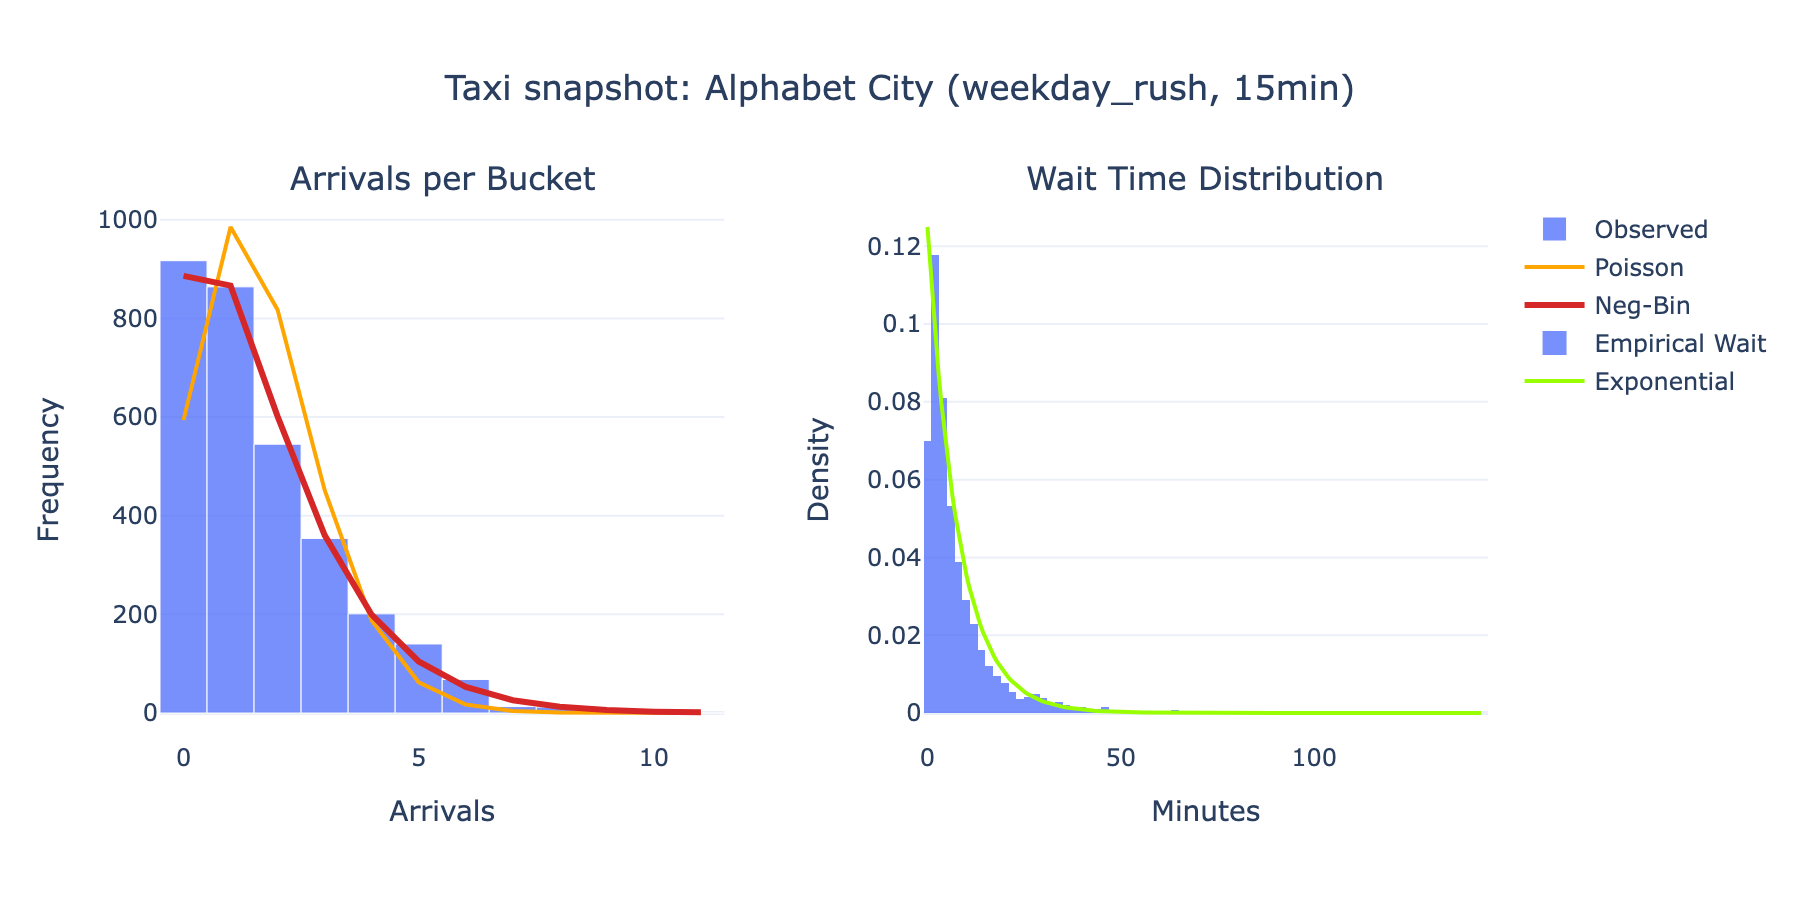

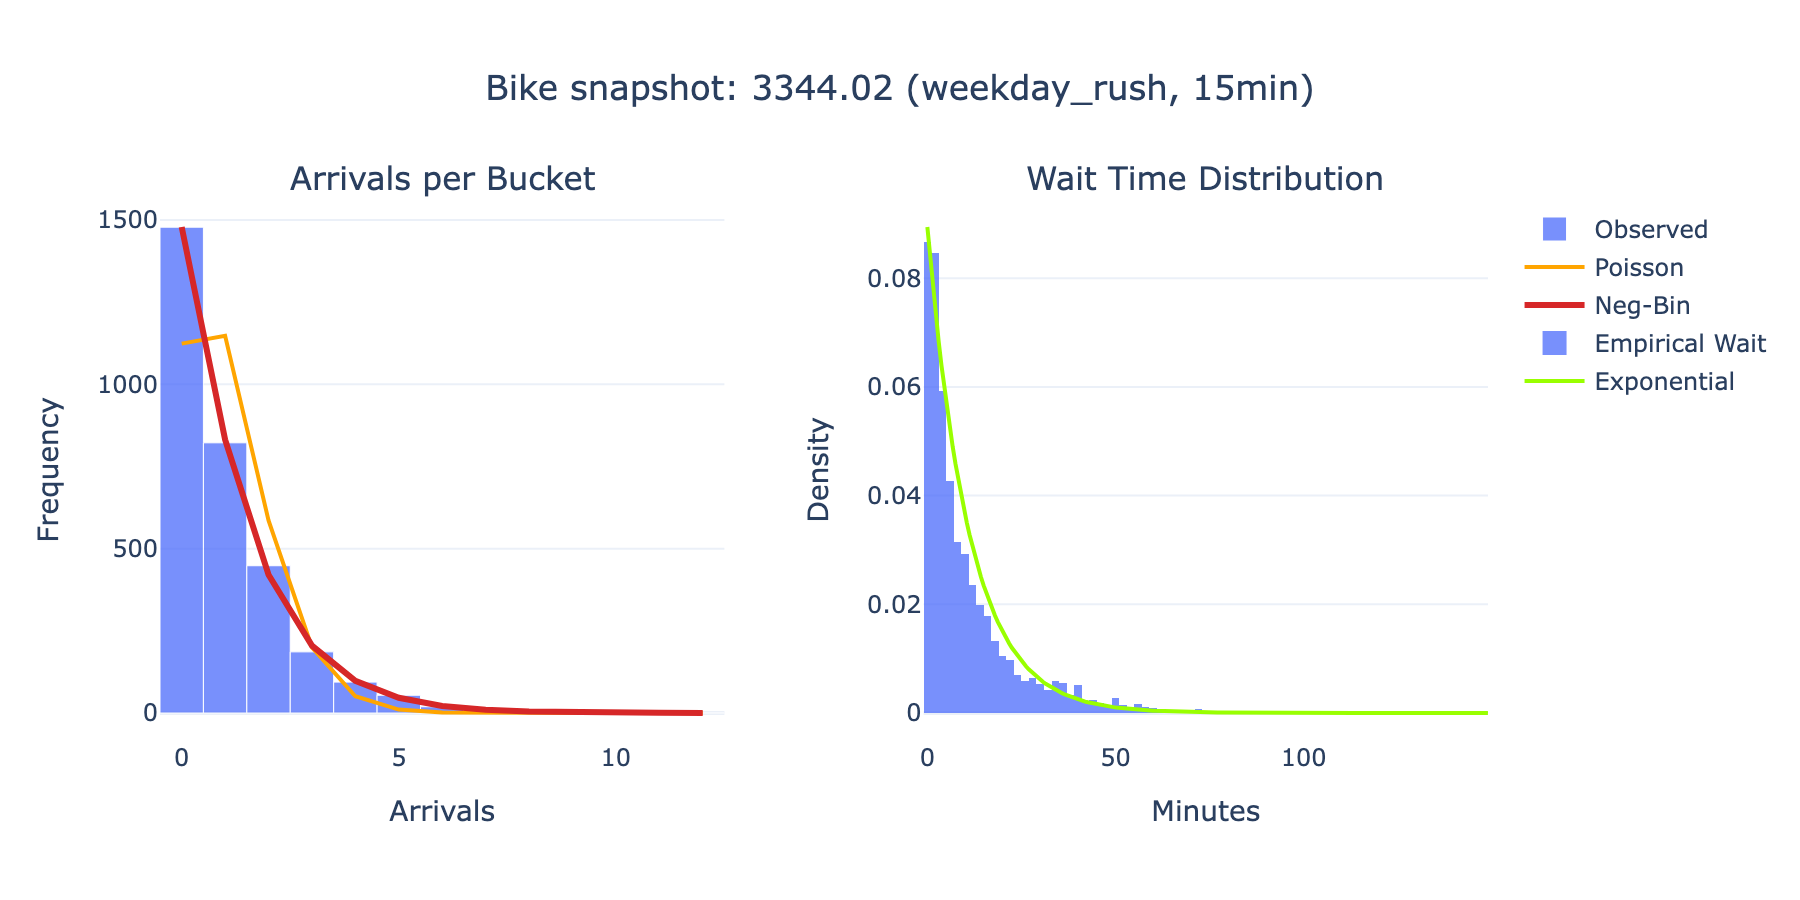

In [8]:

def render_wait_snapshot(trips_data, group_col, location, *, cohort='All trips', freq='15min', title_prefix='Snapshot'):
    subset = trips_data if cohort == 'All trips' else trips_data[trips_data['cohort'] == cohort]
    if subset.empty:
        display(Markdown(f"No data for {cohort} cohort."))
        return
    counts = bucket_counts_by_group(subset, freq=freq, group_cols=group_col)
    if location not in counts.columns:
        display(Markdown(f"Location {location} missing."))
        return
    series = counts[location]
    mean = series.mean()
    nonzero_frac = (series > 0).mean()
    if mean < 0.1 or nonzero_frac < 0.1:
        display(Markdown("Selection too sparse for snapshot."))
        return
    var = series.var(ddof=0)
    nb_r, nb_p = fit_nb(series)
    location_subset = subset[subset[group_col] == location].sort_values('event_time')
    diffs = location_subset['event_time'].diff().dropna().dt.total_seconds() / 60
    diffs = diffs[(diffs > 0) & (diffs < 180)]
    wait_mean = diffs.mean() if not diffs.empty else 0
    fig = create_combined_figure(series, mean, var, nb_r, nb_p, diffs, wait_mean,
                                 f"{title_prefix}: {location} ({cohort}, {freq})")
    png = fig.to_image(format='png', width=900, height=450, scale=2)
    display(Image(png))

render_wait_snapshot(taxi_trips, taxi_group_col, taxi_zones[0], cohort='weekday_rush', title_prefix='Taxi snapshot')
render_wait_snapshot(bike_trips, bike_group_col, bike_stations[0], cohort='weekday_rush', title_prefix='Bike snapshot')
